# Último intento de GA


### Importar las librerías necesarias

*Import the necessary libraries*

In [129]:
import numpy as np
import random
from sympy import symbols, parse_expr, lambdify, srepr, sympify
import matplotlib.pyplot as plt
import time
x = symbols('x')

import logging
# Configuración básica del registro
logging.basicConfig(level=logging.INFO)

import warnings

# Ignorar todas las advertencias de RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Se extraen los datos de el parámetro de Hubble que se ajustarán a una función por encontrar.

*Hubble parameter data is extracted to be fitted to a function to find.*

In [130]:

# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

La clase Create_Individual crea un individuo con un numero de cromosomas específico tal que: 

1. Si se le entregan 5 cromosomas el individuo tendrá 6. 
2. El individuo será una lista del tipo: ['x', '+', '1'] donde cada string es un cromosoma.
3. Los índices pares y el $0$ son expresiones. 
4. Los índices impares partiendo del $1$ son operaciones.
5. Si se le entrega a Create_Individual un individuo ya creado desde antes, devuelve ese individuo. 
6. Cabe recalcar que en un inicio el individuo es del tipo Create_Individual, y el método obtain_expression() entrega la expresion como una lista de strings. 

The Create_Individual class creates an individual with a specific chromosome number such that:

1. If 5 chromosomes are given, the individual will have 6.
2. The individual will be a list of the type: ['x', '+', '1'] where each string is a chromosome.
3. The even indices and $0$ are expressions.
4. Odd indices starting from $1$ are operations.
5. If an individual already created before is given to Create_Individual, it returns that individual.
6. It should be remembered that initially the individual is of type Create_Individuals, and the obtain_expression() method delivers the expression as a list of strings.

In [131]:
class Create_Individual:
    def __init__(self, params, expression = None):
        if expression is None:
            genes = [np.random.choice(params['genes']) for _ in range(0, params['number_of_genes'] + 1, 2)]
            operations = [np.random.choice(params['operaciones']) for _ in range(1, params['number_of_genes'] + 1, 2)]
            self.expression = [valor for par in zip(genes, operations) for valor in par] + [np.random.choice(params['genes'])] #se le suma un gen para que quede una funcion al final/No cambia el numero de cromosomas
        else:
            self.expression = [valor for valor in expression]

    def obtain_expressions(self): #da los cromosomas del individuo
        return self.expression

La clase Create_Generation crea una población inicial, la cual pasa por los siguientes procesos: 

1. Se eligen los padres más aptos de la poblacion inicial
2. Se combinan para generar cierta cantidad de hijos por cada uno
3. Dentro de tales hijos, cierta cantidad se muta

The Create_Generation class creates an initial population, which goes through the following processes:

1. The fittest parents are chosen from the initial population
2. They combine to generate a certain number of children for each one
3. Within such children, a certain amount is mutated

In [132]:
class Create_Generation:
    def __init__(self, ind_parameters, pop_parameters, fitness_function, expression = None):
        #Crea una poblacion inicial
        self.size = pop_parameters['size'] # Tamaño poblacion
        self.initial_poblation = ind_parameters['genes']
        self.initial_operation = ind_parameters['operaciones']
        self.mutation_rate = pop_parameters['mutation_rate']
        self.selection_rate = pop_parameters['selection _rate']
        self.fitness_function = fitness_function 
        self.x = symbols('x')

        if expression == None:
            self.individuals = [Create_Individual(ind_parameters)  for _ in range(self.size)]
        else:
            self.individuals = [Create_Individual(ind_parameters, expression = expression[i]) for i in range(len(expression))]

    def child(self, parent, parent2, crossover_point):
        kid = []
        if len(parent) == 1 and len(parent2) == 1:
            kid = parent
        elif len(parent) == 1:
            kid[:0] = parent
            kid[1:] = parent2[1:]
        elif len(parent2) == 1:
            kid[:0] = parent2
            kid[1:] = parent[1:]
        else:                
            kid[:crossover_point] = parent[:crossover_point]
            kid[crossover_point:] = parent2[crossover_point:]
        return kid

    def funcion(self, individuo): # transforma a funcion lambify los individuos de la poblacion expresados como ['x', '**' '2'] por ejemplo
        expresion_simbolica = sympify(' '.join(individuo.obtain_expressions()))
        x = symbols('x')
        funcion = lambdify(x, expresion_simbolica, 'numpy')
        return funcion  

    def get_parents(self, poblacion) -> np.array: # pares son expresiones e impares son operaciones
        n_parents = int((self.selection_rate)/100 * len(poblacion))
        parents = poblacion
        parents_function = [self.funcion(expresion) for expresion in parents]
        parents_evaluate = [funcion(z) for funcion in parents_function]
        Chi = [self.fitness_function(function) for function in parents_evaluate]
        Minor_Chi = min(Chi)
        sorted_parents = [x for _, x in sorted(zip(Chi, parents), key=lambda pair: pair[0])]
        selected_parents = sorted_parents[:n_parents]
        non_selectec_parents = sorted_parents[n_parents:]
        r1 = random.random()
        r2 = random.random()
        no_apto = random.choice(non_selectec_parents)
        no_apto2 = random.choice(non_selectec_parents)
        if r1>r2:
            Selected_parents = selected_parents + [no_apto] + [no_apto2]
        else:
            Selected_parents = selected_parents
        return Selected_parents, Minor_Chi
    
    def crossover(self, parents: np.array) -> np.array:
        parents = [expresion.obtain_expressions() for expresion in parents]
        offspring = []
        for parent in parents:
            crossover_point = random.choice(range(1, len(parents))) #se elige un numero entre 1 y el penultimo cromosoma para que siempre haya crossover
            parent2 = random.choice(parents)
            parent3 = random.choice(parents)
            parent4 = random.choice(parents)
            parent5 = random.choice(parents)
            parent6 = random.choice(parents)
            kid = self.child(parent, parent2, crossover_point)
            kid2 = self.child(parent, parent3, crossover_point)
            kid3 = self.child(parent, parent4, crossover_point)
            kid4 = self.child(parent, parent5, crossover_point)
            kid5 = self.child(parent, parent6, crossover_point)
            offspring.append(kid)
            offspring.append(kid2)
            offspring.append(kid3)
            offspring.append(kid4)
            offspring.append(kid5)

        return offspring
    
    def mutate(self, offspring_crossover) -> np.array: # contras: a veces se pude mutar el mismo individuo
        num_mutations = int(len(offspring_crossover)*self.mutation_rate/100)
        for num in range(num_mutations):
            idx_mutation = random.choice(range(len(offspring_crossover))) # se elige individuo que se va a mutar
            ind_mutate = offspring_crossover[idx_mutation]
            g = random.choice(range(len(ind_mutate))) #numero de gen que se va a mutar
            if g % 2 == 0 or g==0:
                new_gen = random.choice(self.initial_poblation)
                ind_mutate[g] = new_gen
            else:
                new_gen = random.choice(self.initial_operation)
                ind_mutate[g] = new_gen
        return offspring_crossover

La clase Evolución itera sobre las generaciones requeridas hasta llegar a la última. Durante esta iteración se guardan los menores $\chi^2$ de cada generación. Finalmente devuelve la última generación y los $\chi^2$ antes guardados. 

The Evolution class iterates over the required generations until it reaches the last one. During this iteration the smallest $\chi^2$ of each generation are saved. Finally it returns the last generation and the previously saved $\chi^2$.

In [133]:
class Evolution:
    def __init__(self, gen_parameter, ind_parameters, pop_params, fitness_function): #gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 10, 'num_generations': 100}
        self.selection_rate = gen_parameter['selection_rate']
        self.mutation_rate = gen_parameter['mutation_rate']
        self.num_generations = gen_parameter['num_generations']
        self.fitness_function = fitness_function
        self.ind_parameters = ind_parameters
        self.pop_params = pop_params

    def Iteracion(self):
        inicio_tiempo = time.time()
        Generations = []
        Chi = []
        for n in range(self.num_generations):
            logging.info(f'Número de la generación: {n}')
            if n == 0: 
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function)
                initial_poblation = A.individuals
                parents, minor_chi = A.get_parents(initial_poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)
            else:
                A = Create_Generation(self.ind_parameters, self.pop_params, self.fitness_function, expression = Generations[n-1])
                poblation = A.individuals
                parents, minor_chi = A.get_parents(poblation)
                Chi.append(minor_chi)
                crossover = A.crossover(parents)
                mutation = A.mutate(crossover)
                Generations.append(mutation)

        tiempo_transcurrido = time.time() - inicio_tiempo
        logging.info(f"La evolución tomó {tiempo_transcurrido} segundos en ejecutarse.")
        return Generations[-1], Chi
    

### Prueba del algoritmo

*Algorithm test*

In [134]:
# Se crean los genes iniciales

Genes = ['x**x', '(x+1)', '2']

num_elementos_aleatorios = 3

# Agregar números aleatorios entre 0 y n en forma de cadena. n=1 por default
for _ in range(num_elementos_aleatorios):
    numero_aleatorio = str(random.uniform(0, 1))
    Genes.append(numero_aleatorio)

# Imprime la lista resultante
print(Genes)

['x**x', '(x+1)', '2', '0.34680106762043883', '0.693941429722882', '0.9951483011501365']


In [135]:
# Se entregan los diccionarios que se darán a la clase

pop_params = {'size': 100,'selection _rate': 20, 'mutation_rate' : 10}
ind_parameters = {'genes': Genes, 'operaciones': ['+', '-', '*', '/'], 'number_of_genes': 10}

def Chi(*x): 
    return np.sum(((H - x)/desv)**2)

gen_parameter = {'selection_rate' : 20, 'mutation_rate' : 10, 'num_generations' : 200}

Test1 = Evolution(gen_parameter, ind_parameters, pop_params, Chi)

Results, Chi_square = Test1.Iteracion()

INFO:root:Número de la generación: 0


INFO:root:Número de la generación: 1
INFO:root:Número de la generación: 2
INFO:root:Número de la generación: 3
INFO:root:Número de la generación: 4
INFO:root:Número de la generación: 5
INFO:root:Número de la generación: 6
INFO:root:Número de la generación: 7
INFO:root:Número de la generación: 8
INFO:root:Número de la generación: 9
INFO:root:Número de la generación: 10
INFO:root:Número de la generación: 11
INFO:root:Número de la generación: 12
INFO:root:Número de la generación: 13
INFO:root:Número de la generación: 14
INFO:root:Número de la generación: 15
INFO:root:Número de la generación: 16
INFO:root:Número de la generación: 17
INFO:root:Número de la generación: 18
INFO:root:Número de la generación: 19
INFO:root:Número de la generación: 20
INFO:root:Número de la generación: 21
INFO:root:Número de la generación: 22
INFO:root:Número de la generación: 23
INFO:root:Número de la generación: 24
INFO:root:Número de la generación: 25
INFO:root:Número de la generación: 26
INFO:root:Número de l

## Encontrar Best Fit a partir del algoritmo anterior

*Finding Best Fit from the above algorithm*

El Chi menor fue: 49.751823728766134


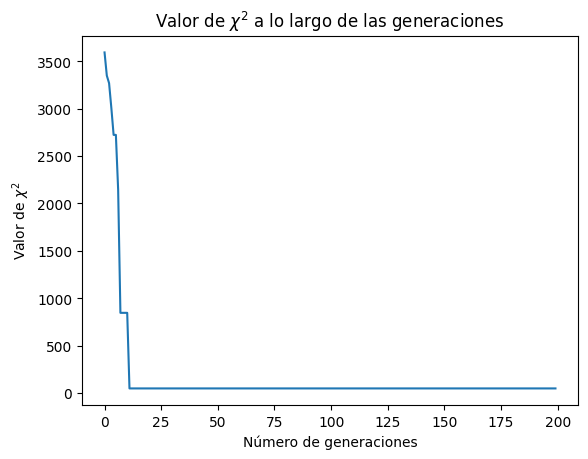

In [144]:
# Evaluacion de Chi

minor_chi = Chi_square
print('El Chi menor fue: ' + str(min(minor_chi)))
num_generaciones = np.arange(0, len(minor_chi), 1)
plt.plot(num_generaciones, minor_chi)
plt.xlabel('Número de generaciones')
plt.ylabel('Valor de $\chi^2$')
plt.title('Valor de $\chi^2$ a lo largo de las generaciones')
plt.show()

In [137]:
def funcion(individuo): # transforma a una expresion los individuos de la forma ['x', '+', '1']
    x = symbols('x')
    if type(individuo) == Create_Individual:
        individuo = individuo.obtain_expressions()
    else:
        individuo = individuo
    expresion_str = ' '.join(individuo)
    return parse_expr(expresion_str, evaluate=False)
    
def seleccionar_funcion_optima(funciones, H, z, desv):
    # Función que calcula chi para una función dada
    def calcular_chi(expresion_funcion):
        funcion = expresion_funcion[1]  # Obtener la función lambdify
        return np.sum(((H - funcion(z)) / desv)**2)

    # Calcular chi para todas las funciones en la lista
    chi_valores = [calcular_chi(expresion_funcion) for expresion_funcion in funciones]

    # Encontrar el índice de la función con el menor valor de chi
    indice_funcion_optima = np.argmin(chi_valores)

    # Devolver la tupla que contiene la expresión simbólica y la función óptima
    expresion_funcion_optima = funciones[indice_funcion_optima]
    chi_minimo = chi_valores[indice_funcion_optima]

    return expresion_funcion_optima, chi_minimo

Funciones_expresion = [funcion(resultado) for resultado in Results]

Funciones = [(expresion, lambdify(x, expresion, 'numpy')) for expresion in Funciones_expresion]

resultado_optimo, chi_minimo = seleccionar_funcion_optima(Funciones, H, z, desv)

# `resultado_optimo` es una tupla que contiene la expresión simbólica y la función lambdify óptima
expresion_optima = resultado_optimo[0]
print(expresion_optima)
funcion_optima_lambdify = resultado_optimo[1]
print(funcion_optima_lambdify)
print('menor chi : ' + str(chi_minimo))

2*(x + 1)*2*2/(0.34680106762043883*0.34680106762043883)
<function _lambdifygenerated at 0x00000196116A60C0>
menor chi : 49.75182372876607


### Listado de Best Fit encontradas

*List of Best Fit found*

In [141]:
def f1(x): 
    '''
    Se encontró después de 200 generaciones
    Su chi^2 = 27.57 aproximadamente
    Los genes iniciales fueron: ['x**x', '(x+1)', '2', '0.5210552124397201', '0.7004391872376786', '0.23680171133428474']
    Tasa de seleccion: 20%
    Tasa de mutacion: 10%
    Tamaño de la poblacion inicial (se conserva la mayoría de las generaciones): 100
    Duración: 2 min aprox
    '''
    return  2*2*(x + 1)/(0.5210552124397201*0.5210552124397201*0.23680171133428474)

def f2(x):
    '''
    Se encontró después de 100 generaciones
    Su chi^2 = 22.26 aproximadamente
    Los genes iniciales fueron: ['x**x', '(x+1)', '0.9758191130231901', '0.6344469961187371', '0.1299935298910112']
    Tasa de seleccion: 20%
    Tasa de mutacion: 10%
    Tamaño de la poblacion inicial (se conserva la mayoría de las generaciones): 100
    Duración: 32 s aprox
    '''
    return  x**x*(x + 1) + (x + 1)/(0.1299935298910112*0.1299935298910112*0.9758191130231901)

def f3(x):
    '''
    Se encontró después de 200 generaciones
    Su chi^2 = 49.75 aproximadamente
    Los genes iniciales fueron: ['x**x', '(x+1)', '2', '0.34680106762043883', '0.693941429722882', '0.9951483011501365']
    Tasa de seleccion: 20%
    Tasa de mutacion: 10%
    Tamaño de la poblacion inicial (se conserva la mayoría de las generaciones): 100
    Duración: 3 min aprox
    '''
    return  2*(x + 1)*2*2/(0.34680106762043883*0.34680106762043883)

In [139]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

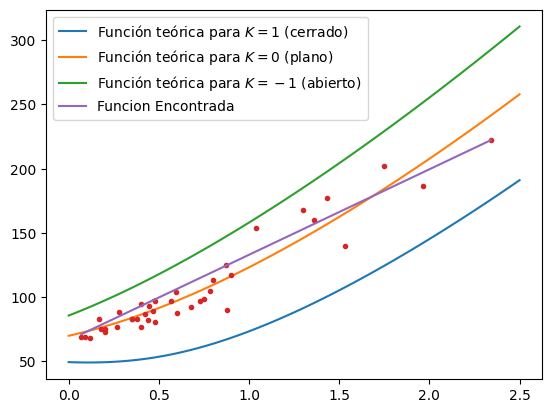

In [140]:
def f1(x):
    return 2/0.1 * 2 + (x+1) * (x+1) / 0.1

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')
plt.plot(z, H, '.')
plt.plot(z, funcion_optima_lambdify(z), label= 'Funcion Encontrada')
plt.legend()
